# PySheaf examples
Michael Robinson

13 December 2018

MIT License

Copyright (c) 2018 Michael Robinson & Steven Fiacco

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pysheaf as ps

# First example: Numerical valued sheaf

Base spaces in PySheaf are always the Alexandrov topology on a preorder.  The preorder is specified by a NetworkX `DiGraph` though the PySheaf `Sheaf` is a subclass of `DiGraph`.  As such, each element in the preorder is a node in the graph labeled with a `Cell` object, which describes the stalk.

The `Cell` object is constructed with a data type name -- for verifying the restriction maps are legal -- and a number of optional arguments that we'll ignore at the moment. While the `Cell` class handles `numpy.arrays` as default, it will happily manage others as well (see second example).

So let's create a `Sheaf` on a partial order with three elements with real valued stalks.

In [2]:
shf=ps.Sheaf()
shf.AddCell('A',ps.Cell('real')) # First argument is the name of the Cell, the second describes the stalk
shf.AddCell('B',ps.Cell('real'))
shf.AddCell('C',ps.Cell('real'))

Now let's add two restriction maps.  By default, PySheaf assumes restrictions are Python function objects wrapped in `Coface` objects, which provide type checking against the stalks.  In any case, these are easily made by anonymous functions.  

In [3]:
shf.AddCoface('A','C',ps.Coface('real','real',lambda x : (0.5 * x)))
shf.AddCoface('B','C',ps.Coface('real','real',lambda x : x))

Let's look at the sheaf we have created.  Since it is a subclass of `DiGraph`, we can use the NetworkX drawing tools

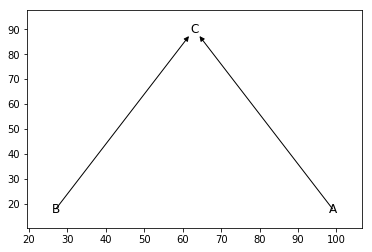

In [4]:
pos=nx.nx_agraph.pygraphviz_layout(shf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(shf,pos)
nx.draw_networkx_edges(shf,pos)

Let's add an assignment! As before, we wrap the actual data in a `Assignment` class to provide type checking

In [5]:
shf.GetCell('A').SetDataAssignment(ps.Assignment('real',1.0))
shf.GetCell('B').SetDataAssignment(ps.Assignment('real',0.0))
shf.GetCell('C').SetDataAssignment(ps.Assignment('real',0.5))

What's the consistency radius of this assignment?  It should be 0.5, because the map from A->C is multiplication by 1/2.

Note that we need to manually propagate out the data from each cell.  This allows us to manage when computations are done somewhat...

In [6]:
shf.MaximallyExtendCell('A')
shf.MaximallyExtendCell('B')
shf.MaximallyExtendCell('C')
print(shf.ComputeConsistencyRadius())

0.5


Let's now swap out for a partial assignment... by deleting the value from C

In [7]:
shf.GetCell('C').mDataAssignmentPresent = False
shf.ClearExtendedAssignments()

The consistency radius of the partial assignment is computed by finding the value for C that minimizes the global consistency radius.  By rights, this is an optimization problem.  That value for C happens to be 0.25, yielding a consistency radius of 0.25.  However, since C is "downstream" of the data, PySheaf gives you a lower bound... it happens to be the right value!

In [8]:
shf.MaximallyExtendCell('A')
shf.MaximallyExtendCell('B')
shf.MaximallyExtendCell('C')
print(shf.ComputeConsistencyRadius())

0.25


Trying a different assignment, which incidentally only obtains a lower bound... the actual consistency radius is 2/3.

In [9]:
shf.GetCell('A').SetDataAssignment(ps.Assignment('real',0.0))
shf.GetCell('B').SetDataAssignment(ps.Assignment('real',1.0))
shf.GetCell('C').SetDataAssignment(ps.Assignment('real',0.5))
shf.MaximallyExtendCell('A')
shf.MaximallyExtendCell('B')
shf.MaximallyExtendCell('C')
print(shf.ComputeConsistencyRadius()) # Should be 2/3

0.5


OK, let's put the assignment back to what it was...

In [10]:
shf.GetCell('A').SetDataAssignment(ps.Assignment('real',1.0))
shf.GetCell('B').SetDataAssignment(ps.Assignment('real',0.0))
shf.GetCell('C').SetDataAssignment(ps.Assignment('real',0.5))
shf.MaximallyExtendCell('A')
shf.MaximallyExtendCell('B')
shf.MaximallyExtendCell('C')

Let's now add another cell to our sheaf, remembering to make some cofaces to hook it up to the others.

In [11]:
shf.AddCell('D',ps.Cell('real'))
shf.AddCoface('D','A',ps.Coface('real','real',lambda x: 2*x))
shf.AddCoface('D','B',ps.Coface('real','real',lambda x: x))

Obligatory sheaf diagram

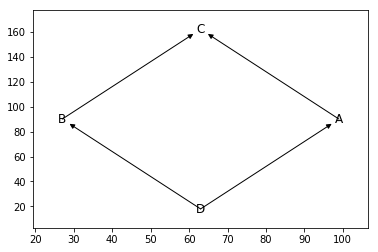

In [12]:
pos=nx.nx_agraph.pygraphviz_layout(shf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(shf,pos)
nx.draw_networkx_edges(shf,pos)

Now to extend our assignment to D, we can't just let PySheaf bound, since D is upstream of the others.  We find it by optimization by a call to `Sheaf.FuseAssignment()`.  We need to mark up the assignment to tell the optimizer which cells to solve and which to leave alone.  Since optimizers like initial guesses, we need to supply those as well!

In [13]:
shf.GetCell('C').mOptimizationCell = True 
shf.GetCell('C').SetDataAssignment(ps.Assignment('real',0.0))
shf.GetCell('D').mOptimizationCell = True 
shf.GetCell('D').SetDataAssignment(ps.Assignment('real',0.0))

In [14]:
shf.FuseAssignment()
for nd in shf.nodes():
    print('Value at {} is {}'.format(nd,shf.GetCell(nd).mDataAssignment))
print('Consistency radius is {}'.format(shf.ComputeConsistencyRadius()))

Value at B is 0.0
Value at C is [0.12962733]
Value at A is 1.0
Value at D is [0.31481711]
Consistency radius is 0.37037266812324576


Here's a different assignment... switching the values of A and B.  Note that the default optimizer is a bit sensitive to the initial values.  Selecting another one is indeed a possibility, but neither here nor there.

In [15]:
shf.GetCell('A').SetDataAssignment(ps.Assignment('real',0.0))
shf.GetCell('B').SetDataAssignment(ps.Assignment('real',1.0))
shf.GetCell('C').mOptimizationCell = True 
shf.GetCell('C').SetDataAssignment(ps.Assignment('real',0.5))
shf.GetCell('D').mOptimizationCell = True 
shf.GetCell('D').SetDataAssignment(ps.Assignment('real',0.5))

In [16]:
shf.FuseAssignment()
for nd in shf.nodes():
    print('Value at {} is {}'.format(nd,shf.GetCell(nd).mDataAssignment))
print('Consistency radius is {}'.format(shf.ComputeConsistencyRadius()))

Value at B is 1.0
Value at C is [0.5]
Value at A is 0.0
Value at D is [0.33333204]
Consistency radius is 0.6666679579940996


Now let's compute the consistency filtration of this assignment.  We do this by computing the open sets that are consistent at different levels.  `Sheaf.ConsistentCollection()` computes an irredundant collection of open sets that are consistent to a given level.  Note that the open sets may not list all elements... just the star elements and their immediate successors.

In [17]:
for threshold in [0.01, 0.4, 0.6, 0.7]:
    print('Sets consistent to {} : {}'.format(threshold,shf.ConsistentCollection(threshold)))

Sets consistent to 0.01 : {frozenset({'C'})}
Sets consistent to 0.4 : {frozenset({'C'})}
Sets consistent to 0.6 : {frozenset({'B', 'C', 'A'})}
Sets consistent to 0.7 : {frozenset({'B', 'A', 'D'})}


# Second example: Graph valued sheaf
This example is a toy example in which the stalks are nodes in various graphs.  This is meant to model the situation of ontology-valued sheaves!

In [18]:
shf2=ps.Sheaf()

Here are three graphs, which will end up representing the stalks over three nodes

In [19]:
g_a=nx.Graph()
g_a.add_edges_from([(0,1),(0,2),(2,3),(2,4)])
g_b=nx.Graph()
g_b.add_edges_from([(0,4),(0,2),(2,1),(2,3)])
g_c=nx.Graph()
g_c.add_edges_from([(0,1),(0,2),(0,3)])

Here's a metric on the nodes of any graph.  We'll use this in the `Cell` instances within our sheaf

In [20]:
def graph_metric(g,n1,n2):
    return(len(nx.shortest_path(g,n1,n2))-1)

Here are the stalks for our sheaf.  Notice both the types and the metric!

In [21]:
shf2.AddCell('A',ps.Cell('g_a',compareAssignmentsMethod=lambda x,y: graph_metric(g_a,x,y)))
shf2.AddCell('B',ps.Cell('g_b',compareAssignmentsMethod=lambda x,y: graph_metric(g_b,x,y)))
shf2.AddCell('C',ps.Cell('g_c',compareAssignmentsMethod=lambda x,y: graph_metric(g_c,x,y)))

The restrictions are defined by graph morphisms...  For this small example, they're just lookup tables.  But notice the type checking!

In [22]:
r_ac = { 0: 0, 1: 1, 2: 0, 3: 2, 4: 3}
r_bc = { 0: 0, 1: 1, 2: 0, 3: 2, 4: 3}
shf2.AddCoface('A','C',ps.Coface('g_a','g_c',lambda x : r_ac[x]))
shf2.AddCoface('B','C',ps.Coface('g_b','g_c',lambda x : r_bc[x]))

Obligatory sheaf diagram... again.

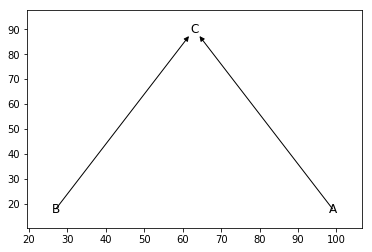

In [23]:
pos=nx.nx_agraph.pygraphviz_layout(shf2,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(shf2,pos)
nx.draw_networkx_edges(shf2,pos)

OK, now let's get some data.  First, a global section

In [24]:
shf2.GetCell('A').SetDataAssignment(ps.Assignment('g_a',2))
shf2.GetCell('B').SetDataAssignment(ps.Assignment('g_b',2))
shf2.GetCell('C').SetDataAssignment(ps.Assignment('g_c',0))

In [25]:
shf2.MaximallyExtendCell('A')
shf2.MaximallyExtendCell('B')
shf2.MaximallyExtendCell('C')
print(shf2.ComputeConsistencyRadius()) # Should return zero

0.0


Not a global section

In [26]:
shf2.GetCell('A').SetDataAssignment(ps.Assignment('g_a',3))
shf2.GetCell('B').SetDataAssignment(ps.Assignment('g_b',2))
shf2.GetCell('C').SetDataAssignment(ps.Assignment('g_c',0))

In [27]:
shf2.MaximallyExtendCell('A')
shf2.MaximallyExtendCell('B')
shf2.MaximallyExtendCell('C')
print(shf2.ComputeConsistencyRadius()) # Should return 1.0

1.0


Consistency filtration is computed in the same way as before!

In [28]:
for threshold in [0.01, 1.5]:
    print('Sets consistent to {} : {}'.format(threshold,shf2.ConsistentCollection(threshold)))

Sets consistent to 0.01 : {frozenset({'B', 'C'})}
Sets consistent to 1.5 : {frozenset({'B', 'C', 'A'})}


The problem now is if we had a partial assignment (for instance if C were blank)... The default optimizer in `Sheaf.FuseAssignment()` doesn't know what to do with our graphy stalks.  We *can* tell it by defining custom optimization methods, but I haven't done that.   

# Coda: Constant sheaves

What if we only have a graph, can we get a sheaf?  Yes! For every partial order, there is automatically a family of sheaves, called *constant sheaves*.  These are defined by a single stalk dimension, and all restriction maps are identity functions.

PySheaf makes it easy to construct these, using a convenience function from the `analysisTools` module

In [29]:
import analysisTools

Any graph we have -- which includes sheaves previously constructed -- can be used to construct a new constant sheaf.  Here are our previous two sheaves used as input.

In [30]:
shf_constant = analysisTools.BuildConstantSheaf(shf)
shf2_constant = analysisTools.BuildConstantSheaf(shf2,dataDimension=2)

The process of constructing a constant sheaf retains the underlying graph structure...

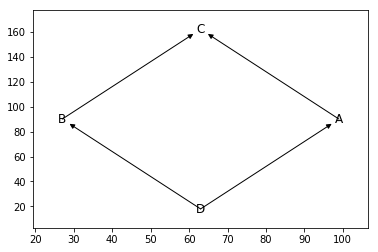

In [31]:
pos=nx.nx_agraph.pygraphviz_layout(shf_constant,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(shf_constant,pos)
nx.draw_networkx_edges(shf_constant,pos)

... while stripping away the restrictions.

In [32]:
for edge in shf_constant.edges():
    print( str(edge) + ": " + str(shf_constant.GetCoface(edge[0],edge[1]).mEdgeMethod.matrix))

('B', 'C'): [[1.]]
('A', 'C'): [[1.]]
('D', 'B'): [[1.]]
('D', 'A'): [[1.]]


If the `dataDimension` is not the default value of 1, then restriction maps are identity maps

In [33]:
for edge in shf2_constant.edges():
    print( str(edge) + ": " + str(shf2_constant.GetCoface(edge[0],edge[1]).mEdgeMethod.matrix))

('B', 'C'): [[1. 0.]
 [0. 1.]]
('A', 'C'): [[1. 0.]
 [0. 1.]]
